In this notebook I explore how different architectural choices in a fully convolutional autoencoder influence the quality of audio reconstruction. The focus is deliberately narrow: instead of building a fancy autoencoder, I want to understand the behaviour of the encoder–decoder backbone itself.

Investigating reconstruction power is the most direct and fundamental way to evaluate an autoencoder as it is its primary purpose. 

$$MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

Good reconstruction suggests the latent representation (z) is meaningful and informative, successfully capturing the essential features of the input data.

The central question is how reconstruction fidelity changes as I vary the main structural parameters of the model. The following dimensinos will be investigated:
- **number of layers** (`n_layers`): controls the depth of both the Encoder and the Decoder. More layers leads to higher compression and forces the network to learn increasingly abstract and complex features.
- **hidden dimension** (`hidden_dim`): the number of output channels for every convolutional layer. At an increasing computational cost, larger dimensions can capture finer details and more orthogonal features,
- **kernel size** (`kernel_size`): the size of the sliding window. A larger kernel captures more context but requires more computation.
- **stride** (`stride`): the step size of the kernel. At 2, each layer effectively halves the input sequence length. Different strides change the compression rate and the resolution of the latent representation.



### Capacity Test (Single Sample Overfitting)
The **Capacity Test** serves as a diagnostic tool to isolate the effect of the network architecture (`n_layers`) from the challenge of learning a diverse dataset.

The goal is to determine the **maximum expressive power** of the Autoencoder architecture. Specifically, we want to find the minimum number of layers (`n_layers`) required for the model to achieve near-perfect reconstruction of a *single, specific input signal* (i.e., to overfit the data completely).

In [1]:
import torch
import torchaudio
import torch.optim as optim
import torch.nn.functional as F

from ae import AE
from datasets import load_dataset

filename = "M01UD01p10"
x, sr = torchaudio.load(f"data/audio/{filename}.wav")

from IPython.display import Audio

Audio(x.detach().squeeze().cpu().numpy(), rate=16000)

In [2]:
T = x.shape[-1]
T_pad = ((T + 63) // 64) * 64
if T_pad != T:
    x = F.pad(x, (0, T_pad - T))  # [1, 1, T_pad]

device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.to(device)
n_layers = 6
hidden_dim=2048
model = AE(hidden_dim=hidden_dim, n_layers=6).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

for step in range(500):
    y = model(x)
    loss = F.mse_loss(y, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100-1 == 0:
        print(f"step {step}: loss = {loss.item():.6f}")

step 0: loss = 0.005243
step 100: loss = 0.002821
step 200: loss = 0.002820
step 300: loss = 0.002819
step 400: loss = 0.002819


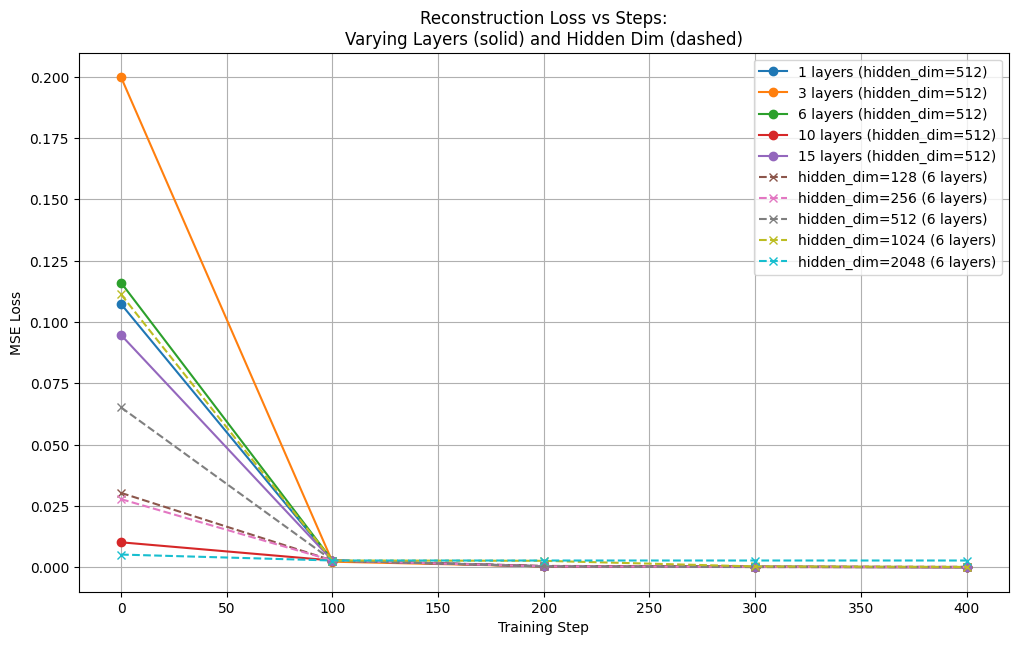

In [4]:
import matplotlib.pyplot as plt

loss_data_layers = {
    1:  {0: 0.107354, 100: 0.002819, 200: 0.000434, 300: 0.000227, 400: 0.000125},
    3:  {0: 0.199801, 100: 0.002333, 200: 0.000433, 300: 0.000251, 400: 0.000127},
    6:  {0: 0.116065, 100: 0.002819, 200: 0.000439, 300: 0.000229, 400: 0.000115},
    10: {0: 0.010238, 100: 0.002818, 200: 0.000393, 300: 0.000162, 400: 0.000090},
    15: {0: 0.094726, 100: 0.002819, 200: 0.000521, 300: 0.000215, 400: 0.000094},
}

loss_data_hidden = {
    128:  {0: 0.030375, 100: 0.002819, 200: 0.000616, 300: 0.000357, 400: 0.000246},
    256:  {0: 0.027838, 100: 0.002811, 200: 0.000433, 300: 0.000265, 400: 0.000145},
    512:  {0: 0.065224, 100: 0.002818, 200: 0.000382, 300: 0.000146, 400: 0.000082},
    1024: {0: 0.111282, 100: 0.002819, 200: 0.002692, 300: 0.000393, 400: 0.000206},
    2048: {0: 0.005243, 100: 0.002821, 200: 0.002820, 300: 0.002819, 400: 0.002819},
}

plt.figure(figsize=(12, 7))

# Plot varying n_layers
for n_layers, losses in loss_data_layers.items():
    steps = list(losses.keys())
    values = list(losses.values())
    plt.plot(
        steps, values, marker="o",
        label=f"{n_layers} layers (hidden_dim=512)",
        linestyle="-"
    )

# Plot varying hidden_dim (fixed n_layers=6)
for hd, losses in loss_data_hidden.items():
    steps = list(losses.keys())
    values = list(losses.values())
    plt.plot(
        steps, values, marker="x",
        label=f"hidden_dim={hd} (6 layers)",
        linestyle="--"
    )

plt.title("Reconstruction Loss vs Steps:\nVarying Layers (solid) and Hidden Dim (dashed)")
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
n_layers=6

In [10]:
from IPython.display import Audio

model.enc.verbose = True
model.dec.verbose = True
with torch.no_grad():
    y = model(x.to(device))

torchaudio.save(f"data/results/{filename}-{n_layers}layers{hidden_dim}hiddendim.wav", y.squeeze().cpu().unsqueeze(0), sample_rate=16000)
Audio(y.detach().squeeze().cpu().numpy(), rate=16000)

Input: torch.Size([1, 122624])
Encoder
After layer 1: torch.Size([2048, 61312])
After layer 2: torch.Size([2048, 30656])
After layer 3: torch.Size([2048, 15328])
After layer 4: torch.Size([2048, 7664])
After layer 5: torch.Size([2048, 3832])
After layer 6: torch.Size([2048, 1916])
Decoder
After layer 1: torch.Size([2048, 3832])
After layer 2: torch.Size([2048, 7664])
After layer 3: torch.Size([2048, 15328])
After layer 4: torch.Size([2048, 30656])
After layer 5: torch.Size([2048, 61312])
Output: torch.Size([1, 122624])


In [11]:
from IPython.display import Audio, display, HTML

base_dir = "data/results"

# 1. Play files for varying n_layers
display(HTML("<h2>Reconstruction by Number of Layers</h2>"))

n_layers_list = [1, 3, 6, 10, 15]

for n_layers in n_layers_list:
    path = f"{base_dir}/{filename}-{n_layers}layers512hiddendim.wav"
    
    display(HTML(f"<h4>{n_layers} layers</h4>"))
    display(Audio(path))


# 2. Play files for varying hidden_dim (fixed n_layers=6)
display(HTML("<hr><h2>Reconstruction by Hidden Dimension (n_layers=6)</h2>"))

hidden_dim_list = [128, 256, 512, 1024, 2048]

for hd in hidden_dim_list:
    path = f"{base_dir}/{filename}-6layers{hd}hiddendim.wav"
    
    display(HTML(f"<h4>hidden_dim = {hd}</h4>"))
    display(Audio(path))


The results turned out to be surprisingly consistent. Regardless of whether the autoencoder had one layer or fifteen layers, the network was able to achieve very good reconstruction quality after only a few hundred optimization steps. Although deeper models compress the temporal dimension more aggressively (each layer halves the length), this did not produce noticeable reconstruction degradation. Probably with 512 hidden channels the latent representation remains extremely expressive, even after many rounds of downsampling. The decoder can learn an effective inverse of the encoder for this specific waveform, and the task quickly reduces to memorizing a near-perfect mapping from the input to itself.

In other words, increasing the number of layers alone does not create a meaningful information bottleneck when the hidden dimensionality is large. The model retains more than enough capacity to reconstruct the signal almost sample-perfectly, even at very high compression ratios. This experiment therefore highlights that depth, by itself, is not the primary factor governing reconstruction quality in convolutional autoencoders. To meaningfully stress the model and expose its limitations, one needs to reduce the hidden dimensionality, alter the downsampling pattern, or introduce a tighter bottleneck such as vector quantization.

A clearer picture emerges when keeping the number of layers fixed and varying the hidden dimensionality. With six layers, the difference between 128 and 256 channels is substantial: the model with 128 hidden channels struggles more to reproduce fine-grained details, whereas 256 channels already grants enough capacity for a clean and stable reconstruction. Interestingly, increasing the width beyond that point yields diminishing returns. The reconstructions for 256, 512, 1024, and even 2048 channels are nearly indistinguishable from one another, both in waveform MSE and in subjective listening tests. Once the latent representation becomes sufficiently wide, further increases in channel count do not translate into perceptible improvements. This reinforces the idea that, in this autoencoder architecture, the effective bottleneck is determined far more by hidden dimensionality than by depth, and that beyond a certain width the decoder simply has all the information it needs to undo the encoder’s transformations.